In [1]:
from black_scholes import BlackScholesPINN
import json
from utils import *
with open("config.json") as f:
    config = json.load(f)

In [ ]:
bs = BlackScholesPINN(config)
bs.train()

# Evaluation
S_eval, t_eval = prepare_dataset(config)
C_pred = bs.predict(S_eval, t_eval).numpy()

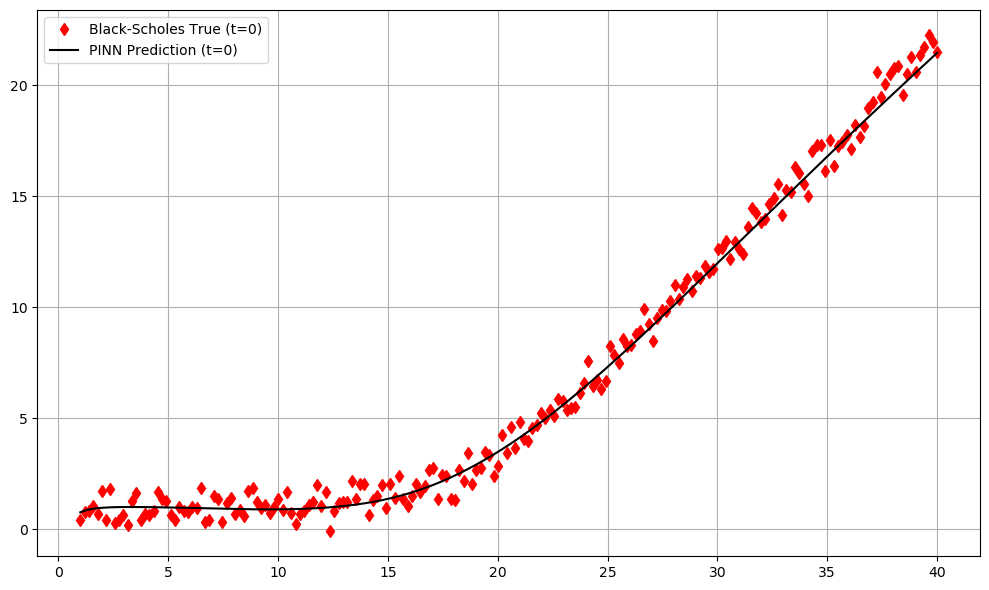

In [9]:
S_np = S_eval.numpy().flatten()
C_true = black_scholes_solution(S_np, config["K"], config["T"], config["r"], config["sigma"]) + config["bias"]
C_true += np.random.normal(0, config["noise_variance"], size=C_true.shape)


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(S_np, C_true, 'd', label="Black-Scholes True (t=0)",color='red')
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='k')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()